In [1]:
%matplotlib inline
import sys
import os
BIN = ''
sys.path.append(BIN)
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

mpl.rc_file(BIN + 'my_matplotlib_rcparams')
import uproot
import ROOT

Welcome to JupyROOT 6.18/04


In [2]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
# Load MC ntuple with 600 GeV mjj peak
path_to_data = '../data/MC/DAOD_EXOT2/'
fname = 'mc16_13TeV.307791.MGPy8EG_N30LO_A14N23LO_DMsA_dijet_mR0p6_gSM0p05.deriv.DAOD_EXOT2.e5687_a875_r9364_p3654/DAOD_EXOT2.15738457._000001.pool.root'
# Load a ROOT file
filePath = path_to_data + fname
tree = uproot.open(filePath)['CollectionTree']

In [4]:
prefix = 'HLT_xAOD__JetContainer_a4tcemsubjesISFSAuxDyn'
branchnames = [
    # 4-momentum
    prefix + '.pt',
    prefix + '.eta',
    prefix + '.phi',
    prefix + '.m',
    # Energy deposition in each calorimeter layer
    # prefix + '.EnergyPerSampling',
    # Area of jet,used for pile-up suppression (4-vector)
    prefix + '.ActiveArea',
    prefix + '.ActiveArea4vec_eta',
    prefix + '.ActiveArea4vec_m',
    prefix + '.ActiveArea4vec_phi',
    prefix + '.ActiveArea4vec_pt',
    # prefix + '.JetGhostArea',
    # Variables related to quality of jet
    prefix + '.AverageLArQF',
    # prefix + '.BchCorrCell',
    prefix + '.NegativeE',
    prefix + '.HECQuality',
    prefix + '.LArQuality',
    # Shape and position, most energetic cluster
    # prefix + '.Width',
    # prefix + '.WidthPhi',
    prefix + '.CentroidR',
    prefix + '.DetectorEta',
    prefix + '.LeadingClusterCenterLambda',
    prefix + '.LeadingClusterPt',
    prefix + '.LeadingClusterSecondLambda',
    prefix + '.LeadingClusterSecondR',
    prefix + '.N90Constituents',
    # Energy released in each calorimeter
    prefix + '.EMFrac',
    prefix + '.HECFrac',
    # Variables related to the time of arrival of a jet
    prefix + '.Timing',
    prefix + '.OotFracClusters10',
    prefix + '.OotFracClusters5',
]

In [5]:
len(branchnames)

25

In [6]:
branchnames[4]

'HLT_xAOD__JetContainer_a4tcemsubjesISFSAuxDyn.ActiveArea'

In [7]:
def get_leading(jaggedX):
    return jaggedX[jaggedX.counts > 0, 0]

In [8]:
def get_subleading(jaggedX):
    return jaggedX[jaggedX.counts > 0, 1]

In [9]:
leading_dict = {}
subleading_dict = {}
for ii, branchname in enumerate(branchnames):
    variable = branchname.split('.')[1]
    jaggedX = tree.array(branchname)
    leadingX = get_leading(jaggedX)
    subleadingX = get_subleading(jaggedX)
    leading_dict.update({variable: leadingX})
    subleading_dict.update({variable: subleadingX})
    if ii % 7 == 0:
        print(str((ii * 100) // len(branchnames)) + '%')
print('100%')
leading_df = pd.DataFrame(data=leading_dict)
subleading_df = pd.DataFrame(data=subleading_dict)

0%
28%
56%
84%
100%


In [10]:
leading_df

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,282143.906250,0.357106,2.052783,17815.330078,0.478719,0.387840,0.129280,2.034354,0.470565,43.899895,...,207.413467,184662.375000,13741.747070,4770.598145,3.0,0.791751,0.000000,-0.064632,0.004992,0.004992
1,357483.812500,-1.675359,2.656734,9989.502930,0.498666,-1.704270,0.139503,2.663534,0.489469,13.800751,...,382.209137,312535.562500,144292.265625,8149.557129,1.0,0.765181,0.222290,-0.063121,0.000000,0.000000
2,251073.390625,-0.163035,-0.061511,17186.111328,0.548532,-0.163706,0.161883,-0.089722,0.537609,63.227493,...,415.136780,197359.937500,158613.781250,10674.870117,2.0,0.719836,0.000000,0.030196,0.000000,0.000000
3,227642.578125,-1.656474,-3.009750,22642.111328,0.498666,-1.685798,0.139847,-3.007620,0.488680,49.186981,...,385.130371,96635.070312,122919.695312,6571.640625,4.0,0.595289,0.364340,0.349498,0.001380,0.028172
4,244356.875000,-0.707400,0.262679,13551.034180,0.508639,-0.715531,0.141122,0.253727,0.499525,14.949917,...,719.343323,216613.359375,405694.593750,29656.050781,1.0,0.630272,0.000000,0.017330,0.000000,0.003572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25103,320144.875000,-0.568237,-0.154590,17803.050781,0.528585,-0.592095,0.150236,-0.167252,0.516959,26.974510,...,263.200409,150725.187500,51208.937500,6694.298340,3.0,0.621394,0.000000,0.008076,0.008696,0.008696
25104,217378.656250,0.421524,-0.206758,15371.302734,0.518612,0.421954,0.144203,-0.200050,0.508664,27.048975,...,334.723633,187618.937500,135312.609375,7579.952148,1.0,0.909646,0.000000,-0.071890,0.000000,0.004819
25105,212672.296875,-1.083554,1.317620,20211.251953,0.468746,-1.098738,0.127954,1.330715,0.460240,48.402004,...,392.938538,102633.070312,38350.109375,7348.679199,5.0,0.748143,0.000000,-0.078537,0.007331,0.007331
25106,205712.109375,1.968570,0.894979,14134.563477,0.558505,2.012528,0.160647,0.908536,0.547760,140.339035,...,207.031555,71464.882812,10814.205078,1380.501953,5.0,0.732184,0.266894,0.046275,0.000000,0.000000


In [11]:
subleading_df

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,268090.562500,1.286533,-1.037295,10843.919922,0.488692,1.316783,0.138009,-1.020096,0.479335,24.749546,...,348.538910,208915.296875,224177.031250,3444.697021,2.0,0.860485,0.000000,0.002606,0.000000,0.000000
1,251275.531250,-1.482292,-0.536224,15076.052734,0.478719,-1.495413,0.131350,-0.535869,0.471300,75.081543,...,1381.852539,130672.296875,352669.468750,9091.567383,5.0,0.445300,0.013950,0.038033,0.000000,0.023870
2,166180.750000,-1.840604,2.744145,14408.623047,0.488692,-1.882184,0.137500,2.730457,0.478195,64.054573,...,902.031189,75803.687500,60152.128906,12936.292969,5.0,0.581615,0.418386,0.198174,0.007848,0.007848
3,132653.250000,-3.279565,0.301404,19495.244141,0.518612,-3.300973,0.145408,0.297427,0.508908,688.209534,...,204.643692,71013.867188,24908.396484,680.529297,5.0,0.774009,0.086638,0.263861,0.000000,0.042061
4,177388.187500,-2.478037,-2.816880,29380.484375,0.508639,-2.488257,0.143580,-2.802939,0.499104,1785.648560,...,236.055817,88518.117188,9493.831055,2426.704346,4.0,0.681085,0.318915,-0.094924,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25103,290601.968750,-0.667732,2.968032,11347.535156,0.468746,-0.705269,0.129461,2.974388,0.459273,7.830382,...,758.317078,222735.046875,449635.031250,19391.644531,2.0,0.615827,0.000000,-0.003868,0.001921,0.001921
25104,177731.640625,0.765701,3.137678,19882.191406,0.508639,0.788831,0.142940,3.127998,0.498495,47.143154,...,722.145142,81669.664062,380629.375000,10205.423828,5.0,0.609851,0.000000,-0.186653,0.000000,0.000000
25105,214943.453125,0.167751,-1.495416,41679.582031,0.608372,0.124564,0.191968,-1.513463,0.595956,28.095512,...,727.760864,112326.320312,314128.906250,13333.468750,5.0,0.440228,0.000000,-0.132424,0.000000,0.000000
25106,146550.859375,1.046927,-1.955736,18339.898438,0.498666,1.073211,0.138474,-1.947795,0.488076,35.436398,...,296.319092,26412.789062,26500.537109,4230.959473,9.0,0.939622,0.000000,-0.254542,0.012962,0.012962


In [12]:
# Save train and test sets
#partial_train.to_pickle('processed_data/aod/partial_train.pkl')
#partial_test.to_pickle('processed_data/aod/partial_test.pkl')
#full_train.to_pickle('processed_data/aod/full_train.pkl')
#full_test.to_pickle('processed_data/aod/full_test.pkl')

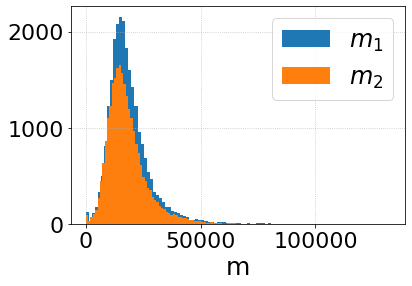

In [13]:
plt.hist(leading_df['m'], bins=100, label='$m_1$')
plt.hist(subleading_df['m'], bins=100, label='$m_2$')
plt.xlabel('m')
plt.legend()
plt.show()

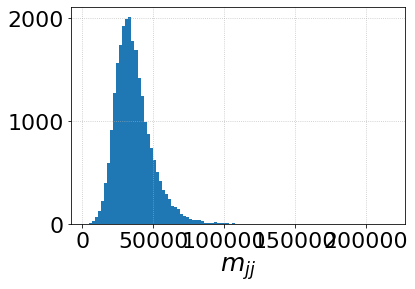

In [14]:
plt.hist(leading_df['m'] + subleading_df['m'], bins=100)
plt.xlabel('$m_{jj}$')
plt.show()

In [15]:
for kk in np.arange(50):
    print(leading_df['pt'][kk], subleading_df['pt'][kk])

282143.9 268090.56
357483.8 251275.53
251073.39 166180.75
227642.58 132653.25
244356.88 177388.19
329610.6 279822.84
180360.53 139764.58
361036.56 269275.66
167675.69 79892.43
160996.58 166806.42
261857.45 232546.66
274205.28 206685.84
292775.66 259331.14
312591.38 274571.75
196175.11 180109.83
186742.95 151052.05
325393.38 301765.28
213903.95 179006.31
281626.75 276373.4
222685.31 200037.08
203197.5 178576.7
201971.2 165639.98
195787.33 81146.55
213301.86 193613.17
241586.66 249283.69
176480.58 121765.555
274341.9 210434.06
163222.36 141588.86
312060.3 267269.56
273584.12 267216.2
236000.28 159973.17
229711.95 219230.02
266527.1 273438.22
301733.3 164207.88
364620.4 222958.08
150355.03 116666.22
239837.72 221240.16
223601.55 123199.016
158107.1 84594.68
266124.28 157942.56
192761.94 171444.27
215962.9 190398.55
214249.2 122387.56
320921.75 262105.42
251331.16 255512.36
214017.9 165035.81
149543.6 105054.83
272408.22 241160.28
241892.92 181321.58
285974.62 173913.78


In [16]:
canv = ROOT.TCanvas("canv", "canvas")
hist = ROOT.TH1D("hist", "Invariant mass", 100, 0, 3000)

In [17]:
for ii in np.arange(len(leading_df)):
    m1 = leading_df['m'][ii] / 1000
    m2 = subleading_df['m'][ii] / 1000
    pT1 = leading_df['pt'][ii] / 1000
    pT2 = subleading_df['pt'][ii] / 1000
    eta1 = leading_df['eta'][ii]
    eta2 = subleading_df['eta'][ii]
    phi1 = leading_df['phi'][ii]
    phi2 = subleading_df['phi'][ii]

    vec4_1 = ROOT.TLorentzVector()
    vec4_1.SetPtEtaPhiM(pT1, eta1, phi1, m1)
    vec4_2 = ROOT.TLorentzVector()
    vec4_2.SetPtEtaPhiM(pT2, eta2, phi2, m2)
    vec4_jj = vec4_1 + vec4_2

    mjj = vec4_jj.M()

    hist.Fill(mjj)

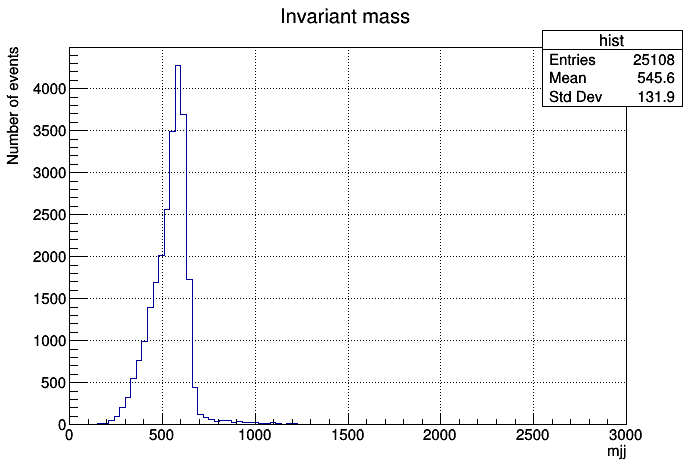

In [18]:
hist.GetXaxis().SetTitle('mjj')
hist.GetYaxis().SetTitle('Number of events')
canv.SetGrid()
hist.Draw()
canv.Draw()

In [19]:
pwd

'/Users/ericwulff/Documents/LTH/Examensarbete/lth_thesis_project'

In [20]:
ls

README.md
__pycache__/
check_split_data.py
check_split_data_all_jets.ipynb
data_exploration.ipynb
data_exploration_figures/
data_exploration_log_normalized.ipynb
environment.yml
environment_20191001.yml
first_tutorials/
jet_by_jet_compression/
my_matplotlib_rcparams
my_matplotlib_style.py
my_nn_modules.py
plot_activation_functions.py
process_AOD_data_all_jets.ipynb
process_AOD_data_leading_all_jets-Copy1.ipynb
process_AOD_data_leading_jets.ipynb
process_MC_data.ipynb
process_ROOT_data.ipynb
process_ROOT_data_all_jets.ipynb
process_ROOT_split_data_all_jets.ipynb
processed_data/
split_data.py
utils.py


In [21]:
ls processed_data

all_jets_test.pkl              small_test.pkl
all_jets_train.pkl             small_train.pkl
aod/                           test.pkl
dijetISRphoton36k_jets.pkl     test1.pkl
dijetISRphoton36k_photons.pkl  tiny_test.pkl
dijetISRphoton36k_test.pkl     tiny_train.pkl
dijetISRphoton36k_train.pkl    train.pkl
mc/                            train2.pkl
